# **Machine Learning Model for Life Expectancy Prediction using `caret`**

## Life Expectancy Dataset: https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who


The dataset related to life expectancy, health factors for 193 countries has been collected from the same WHO data repository website and its corresponding economic data was collected from United Nation website. All predicting variables was then divided into several broad categories:​Immunization related factors, Mortality factors, Economical factors and Social factors.


**Target: ‘Life expectancy’**

### **Install Libraries**

In [185]:
install.packages('caret')
install.packages('glmnet')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### **Import Libraries**

In [186]:
library(tidyverse)
library(caret)

### **Explore Data**

In [187]:
# import data
life <- read_csv("Life_Expectancy.csv")
summary(life)   # summary of dataset

Rows: 2938 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Country, Status
dbl (20): Year, Life expectancy, Adult Mortality, infant deaths, Alcohol, pe...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


   Country               Year         Status          Life expectancy
 Length:2938        Min.   :2000   Length:2938        Min.   :36.30  
 Class :character   1st Qu.:2004   Class :character   1st Qu.:63.10  
 Mode  :character   Median :2008   Mode  :character   Median :72.10  
                    Mean   :2008                      Mean   :69.22  
                    3rd Qu.:2012                      3rd Qu.:75.70  
                    Max.   :2015                      Max.   :89.00  
                                                      NA's   :10     
 Adult Mortality infant deaths       Alcohol        percentage expenditure
 Min.   :  1.0   Min.   :   0.0   Min.   : 0.0100   Min.   :    0.000     
 1st Qu.: 74.0   1st Qu.:   0.0   1st Qu.: 0.8775   1st Qu.:    4.685     
 Median :144.0   Median :   3.0   Median : 3.7550   Median :   64.913     
 Mean   :164.8   Mean   :  30.3   Mean   : 4.6029   Mean   :  738.251     
 3rd Qu.:228.0   3rd Qu.:  22.0   3rd Qu.: 7.7025   3rd Qu.:  441

In [188]:
# change column names -> remove punctuation and whitespace, then replace them with an underscore
life <- life %>% 
  rename_with(~ tolower(gsub('[[:punct:]]', ' ', .x))) %>% 
  rename_with(~ gsub(' ', '_', .x))

# convert the country and status columns to factors
life$country <- factor(life$country)
life$status <- factor(life$status,
                      levels = c("Developing", "Developed"),
                      labels = c(0, 1))

glimpse(life)

Rows: 2,938
Columns: 22
$ country                         <fct> Afghanistan, Afghanistan, Afghanistan,…
$ year                            <dbl> 2015, 2014, 2013, 2012, 2011, 2010, 20…
$ status                          <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ life_expectancy                 <dbl> 65.0, 59.9, 59.9, 59.5, 59.2, 58.8, 58…
$ adult_mortality                 <dbl> 263, 271, 268, 272, 275, 279, 281, 287…
$ infant_deaths                   <dbl> 62, 64, 66, 69, 71, 74, 77, 80, 82, 84…
$ alcohol                         <dbl> 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.…
$ percentage_expenditure          <dbl> 71.279624, 73.523582, 73.219243, 78.18…
$ hepatitis_b                     <dbl> 65, 62, 64, 67, 68, 66, 63, 64, 63, 64…
$ measles                         <dbl> 1154, 492, 430, 2787, 3013, 1989, 2861…
$ bmi                             <dbl> 19.1, 18.6, 18.1, 17.6, 17.2, 16.7, 16…
$ under_five_deaths               <dbl> 83, 86, 89, 93, 97, 102, 106, 110, 113…
$ polio         

In [189]:
# check to see if there are missing data
cat("The number of rows:", nrow(life))        
cat("\nTotal missing values in the dataset:", sum(is.na(life)))
cat("\nThe number of complete rows:", sum(complete.cases(life)))
cat("\nThe proportion of complete rows:", mean(complete.cases(life)))

The number of rows: 2938
Total missing values in the dataset: 2563
The number of complete rows: 1649
The proportion of complete rows: 0.5612662

In [190]:
# the frequency of the country column -> top 15 countries in ascending order
life %>%
  group_by(country) %>%
  summarise(n=n()) %>%
  arrange(n) %>%
  head(15)

# remove 10 countries that appear only once
appearOnce <- life %>% 
  group_by(country) %>%
  summarise(n = n()) %>%  
  filter(n < 16)

life <- life %>%
  filter(!(country %in% appearOnce$country))

country,n
<fct>,<int>
Cook Islands,1
Dominica,1
Marshall Islands,1
Monaco,1
Nauru,1
Niue,1
Palau,1
Saint Kitts and Nevis,1
San Marino,1


### **Split Data**

In [191]:
# create a train_test_split function
train_test_split <- function(data, train_size = 0.7) {      # default trainning set = 70%
  set.seed(70)                           
  n <- nrow(data)
  id <- sample(1:n, size = n*train_size)
  train_data <- data[id, ]
  test_data <- data[-id, ]
  
  return(list(train_data, test_data))
}

In [192]:
# split data
split_data <- train_test_split(life)
train_data <- split_data[[1]]
test_data <- split_data[[2]]

summary(train_data)     # summary of the trainning data

                country          year      status   life_expectancy
 Chile              :  16   Min.   :2000   0:1698   Min.   :36.30  
 Austria            :  15   1st Qu.:2003   1: 351   1st Qu.:63.10  
 Fiji               :  15   Median :2007            Median :72.00  
 Republic of Korea  :  15   Mean   :2007            Mean   :69.18  
 Zimbabwe           :  15   3rd Qu.:2011            3rd Qu.:75.80  
 Antigua and Barbuda:  14   Max.   :2015            Max.   :89.00  
 (Other)            :1959                                          
 adult_mortality infant_deaths        alcohol       percentage_expenditure
 Min.   :  1.0   Min.   :   0.00   Min.   : 0.010   Min.   :    0.000     
 1st Qu.: 74.0   1st Qu.:   0.00   1st Qu.: 0.960   1st Qu.:    4.113     
 Median :144.0   Median :   3.00   Median : 3.840   Median :   63.878     
 Mean   :164.8   Mean   :  29.14   Mean   : 4.669   Mean   :  704.981     
 3rd Qu.:227.0   3rd Qu.:  21.00   3rd Qu.: 7.810   3rd Qu.:  437.106     
 Max. 

In [193]:
# the bagging imputation method for filling in missing data
set.seed(37)
bagMissing <- preProcess(train_data, method = "bagImpute")
train_data <- predict(bagMissing, newdata = train_data)

cat("\nTotal missing values in the dataset:", sum(is.na(train_data)))
cat("\nThe proportion of complete rows:", mean(complete.cases(train_data)))


Total missing values in the dataset: 0
The proportion of complete rows: 1

In [194]:
## k-fold target encoding for the country column
# create the k-value for each row -> 5 folds
set.seed(123)
train_data <- train_data %>% 
  mutate(k = sample(1:5, size = nrow(.), replace = TRUE))

train_data %>% 
  select(country, k) %>% 
  head(10)

country,k
<fct>,<int>
Gambia,3
Czechia,3
Benin,2
Croatia,2
Nepal,3
Slovenia,5
Papua New Guinea,4
Republic of Moldova,1
Burundi,2


In [195]:
# k-fold target encoding function
target_enc <- function(data, enc_col, tar_col, k_col,
                       kmin, kmax){
  require(tidyverse)
  col_name <- paste0("tar_enc_", enc_col)
  
  temp <- map_df(kmin:kmax, function(k){
    
    xtrain <- data[data[k_col] != k, ]
    xvalid <- data[data[k_col] == k, ]
    
    feat <- xtrain %>% 
      group_by_at(.vars = enc_col) %>%
      summarise_at(.vars = tar_col, .funs = mean)   # the mean of the output based on each category
    
    colnames(feat)[2] <- col_name
    temp_df <- xvalid %>% 
      left_join(feat, by = enc_col) %>% 
      select(all_of(enc_col), all_of(col_name))
    
    return(temp_df)
  })
  
  temp_enc <- temp %>% 
    group_by_at(.vars = enc_col) %>% 
    summarise_at(.vars = col_name, .funs = mean) %>%    # the mean of encoded categories from all folds
    ungroup()
  
  data %>% 
    left_join(temp_enc, by = enc_col)
}

In [196]:
# encode training data
train_data <- target_enc(data = train_data, 
                                 enc_col = "country",           # the column to be encoded
                                 tar_col = "life_expectancy",   # the target column
                                 k_col = "k",
                                 kmin = 1, kmax = 5)            # 5 folds

train_data %>% 
  distinct(country, tar_enc_country) %>% 
  head(10)

country,tar_enc_country
<fct>,<dbl>
Gambia,59.53029
Czechia,76.87565
Benin,57.44955
Croatia,75.84111
Nepal,66.31357
Slovenia,80.07917
Papua New Guinea,62.06704
Republic of Moldova,69.21841
Burundi,55.95390


In [197]:
# apply the same transformations to the test data
test_data <- predict(bagMissing, test_data)


set.seed(123)
test_data <- test_data %>% 
  mutate(k = sample(1:5, size = nrow(.), replace = TRUE))

test_data <- target_enc(data = test_data, 
                         enc_col = "country",
                         tar_col = "life_expectancy", 
                         k_col = "k",
                         kmin = 1, kmax = 5)


names(test_data) <- names(train_data)       # make sure the names are the same

In [198]:
# !!! after encoding, the encoded test data have some missing values on the tar_enc_col column due to the lack of data
test_data %>% 
  distinct(country, tar_enc_country) %>%
  head(10) 

# remove rows that have missing values
test_data <- test_data %>% 
  filter(!is.na(tar_enc_country)) 

country,tar_enc_country
<fct>,<dbl>
Afghanistan,57.75000
Albania,75.41238
Algeria,73.36500
Angola,48.23333
Antigua and Barbuda,76.00000
Argentina,75.21667
Armenia,73.68167
Australia,81.72500
Austria,NA


### **Build Training Models**

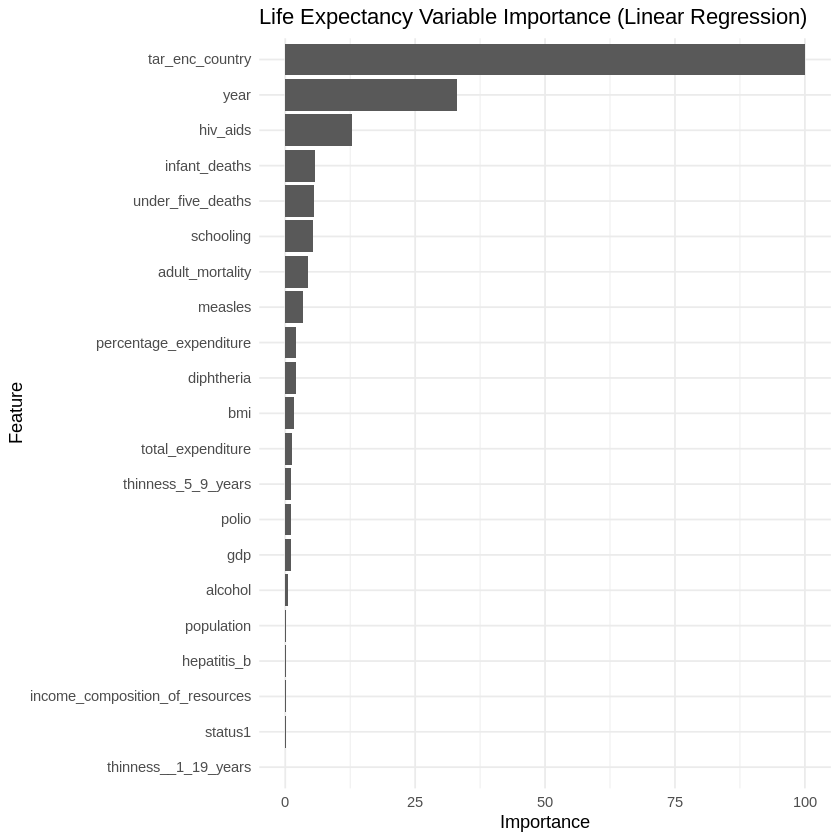

In [199]:
## linear regression
set.seed(5)
ctrl <- trainControl(method = "repeatedcv",
                     number = 5,
                     repeats = 5, 
                     verboseIter = FALSE)

lm_model <- train(life_expectancy ~ . - country - k,
            data = train_data,
            method = "lm",
            na.action = na.omit,
            trControl = ctrl)

# varImp(lm_model)
ggplot(varImp(lm_model)) +
  theme_minimal() +
  labs(title = "Life Expectancy Variable Importance (Linear Regression)")

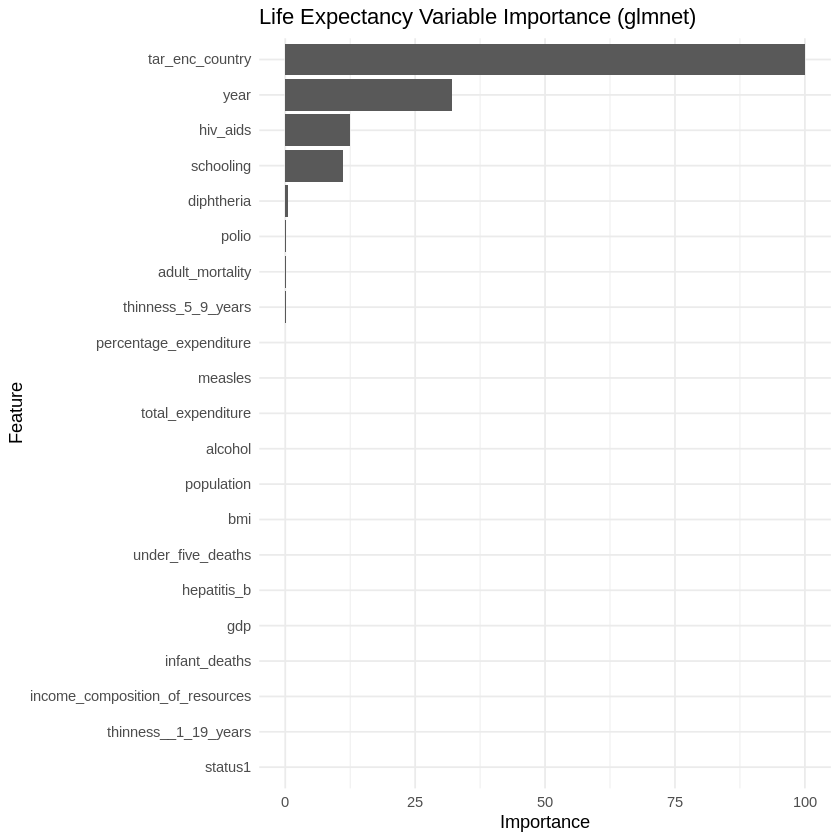

In [200]:
## ridge, lasso, and elastic net regression
set.seed(5) 
grid <- expand.grid(alpha = c(0, 0.25, 0.5, 0.75, 1),  # 0 = ridge, 1 = lasso
                    lambda = seq(0, 1, by=0.25))

glmnet_model <- train(life_expectancy ~ . - country - k,
               data = train_data,
               method = "glmnet",
               na.action = na.omit,
               tuneGrid = grid,
               trControl = ctrl)

# varImp(glmnet_model)
ggplot(varImp(glmnet_model)) +
  theme_minimal() +
  labs(title = "Life Expectancy Variable Importance (glmnet)")

### **Scoring/ Prediction**

In [201]:
# linear regression model
p_train_lm <- predict(lm_model)
p_test_lm <- predict(lm_model, newdata = test_data)

In [202]:
# glmnet model
p_train_glmnet <- predict(glmnet_model)
p_test_glmnet <- predict(glmnet_model, newdata = test_data)

### **Model Evaluation**

In [203]:
# linear regression model
lm_model

cat("\n\nRMSE of the training data:", RMSE(p_train_lm, train_data$life_expectancy))
cat("\nRMSE of the test data:", RMSE(p_test_lm, test_data$life_expectancy))

Linear Regression 

2049 samples
  23 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 1638, 1639, 1640, 1640, 1639, 1639, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1.983151  0.9569599  1.279932

Tuning parameter 'intercept' was held constant at a value of TRUE



RMSE of the training data: 1.966967
RMSE of the test data: 1.889534

In [204]:
# glmnet model
glmnet_model

cat("\n\nRMSE of the training data:", RMSE(p_train_glmnet, train_data$life_expectancy))
cat("\nRMSE of the test data:", RMSE(p_test_glmnet, test_data$life_expectancy))

glmnet 

2049 samples
  23 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 1638, 1639, 1640, 1640, 1639, 1639, ... 
Resampling results across tuning parameters:

  alpha  lambda  RMSE      Rsquared   MAE     
  0.00   0.00    2.299029  0.9440434  1.584786
  0.00   0.25    2.299029  0.9440434  1.584786
  0.00   0.50    2.299029  0.9440434  1.584786
  0.00   0.75    2.299029  0.9440434  1.584786
  0.00   1.00    2.329421  0.9426949  1.611675
  0.25   0.00    1.991283  0.9566214  1.288593
  0.25   0.25    2.018435  0.9558915  1.307509
  0.25   0.50    2.085947  0.9540113  1.355945
  0.25   0.75    2.169737  0.9517123  1.420164
  0.25   1.00    2.259952  0.9492903  1.493620
  0.50   0.00    1.990498  0.9566520  1.284830
  0.50   0.25    2.012791  0.9562998  1.278860
  0.50   0.50    2.073491  0.9553444  1.310424
  0.50   0.75    2.161803  0.9539536  1.380735
  0.50   1.00    2.270955  0.9521614  1.478418
  0.75   0.00    1.99085



RMSE of the training data: 1.981669
RMSE of the test data: 1.879851